In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset

In [2]:
dataset='bone_tumor'

from loader import DataLoader
dl = DataLoader()
primitive_matrix, ground = dl.load_data(dataset=dataset)

In [3]:
#TODO formalize
train_primitive_matrix = primitive_matrix[0:400,:]
train_ground = ground[0:400]

val_primitive_matrix = primitive_matrix[400:600,:]
val_ground = ground[400:600]

## Synthesize Heuristics

In [4]:
from synthesizer import Synthesizer
syn = Synthesizer(val_primitive_matrix, val_ground)

In [5]:
hf, feat_combos = syn.generate_heuristics(cardinality=1)

#optional pruning
# sort_idx = syn.prune_heuristics(hf,feat_combos, keep=30)
# hf = [hf[i] for i in sort_idx]
# feat_combos = [feat_combos[i] for i in sort_idx]

In [6]:
X_train = train_primitive_matrix[:,feat_combos]
L_train = syn.apply_heuristics(hf,X_train)

X_val = val_primitive_matrix[:,feat_combos]
L_val = syn.apply_heuristics(hf,X_val)

## Verify Heuristics

In [7]:
from verifier import Verifier
vf = Verifier(L_train, L_val, val_ground)

In [8]:
vf.train_gen_model()
vf.gen_model.learned_lf_stats()

Inferred cardinality: 2


,Accuracy,Coverage,Precision,Recall
0,0.891871,0.7602,0.934155,0.678503
1,0.901966,0.7732,0.939355,0.693698
2,0.902394,0.7602,0.946440,0.686820
3,0.901465,0.7713,0.943603,0.687780
4,0.860016,0.7508,0.909662,0.649072
5,0.847133,0.7307,0.899513,0.619962
6,0.875975,0.7434,0.921976,0.659629
7,0.819359,0.7180,0.882521,0.591171
8,0.876614,0.7513,0.922387,0.657710
9,0.883349,0.7561,0.927527,0.669386


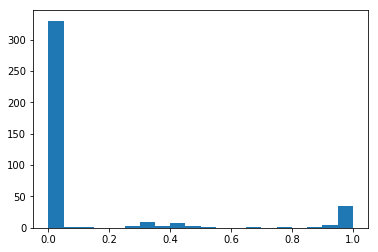

In [9]:
vf.assign_marginals()
plt.hist(vf.train_marginals, bins=20)
plt.show()

In [10]:
vague_idx = vf.find_vague_points(b=0.6, thresh=0.2)
incorrect_idx = vf.find_incorrect_points(b=0.6)
#TODO call the function, print TP/FP/F1/P/R etc in pandas format
1-np.shape(incorrect_idx)[0]/float(np.shape(val_ground)[0])

0.61

## Re-Synthesize Labeling Functions

In [11]:
special_idx = list(set(list(np.concatenate((vague_idx,incorrect_idx)))))

In [12]:
syn = Synthesizer(val_primitive_matrix[special_idx,:], val_ground[special_idx])

In [13]:
hf, feat_combos = syn.generate_heuristics(cardinality=2)

In [14]:
#optional pruning
sort_idx = syn.prune_heuristics(hf,feat_combos, keep=10)
hf = [hf[i] for i in sort_idx]
feat_combos = [feat_combos[i] for i in sort_idx]

In [15]:
X_train = train_primitive_matrix[:,feat_combos]
L_train_new = syn.apply_heuristics(hf,X_train)

X_val = val_primitive_matrix[:,feat_combos]
L_val_new = syn.apply_heuristics(hf,X_val)

In [16]:
L_train_all = np.concatenate((L_train,L_train_new), axis=1)
L_val_all = np.concatenate((L_val,L_val_new), axis=1)

In [17]:
from verifier import Verifier
vf = Verifier(L_train_all, L_val_all, val_ground)

In [18]:
vf.train_gen_model()
vf.gen_model.learned_lf_stats()

Inferred cardinality: 2


,Accuracy,Coverage,Precision,Recall
0,0.844218,0.7350,0.913655,0.621773
1,0.837553,0.7307,0.907496,0.604768
2,0.829545,0.7304,0.903938,0.602946
3,0.835147,0.7352,0.909749,0.610689
4,0.861939,0.7446,0.919394,0.635591
5,0.792924,0.7123,0.876887,0.564531
6,0.905919,0.7738,0.952195,0.701640
7,0.843695,0.7383,0.912576,0.618129
8,0.912876,0.7782,0.955710,0.707713
9,0.914628,0.7848,0.955215,0.718949


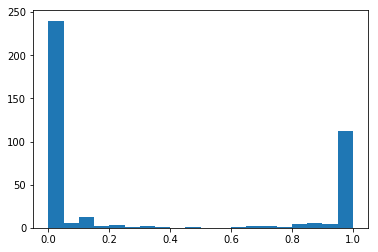

In [19]:
vf.assign_marginals()
plt.hist(vf.train_marginals, bins=20)
plt.show()

In [20]:
vague_idx = vf.find_vague_points(b=0.6, thresh=0.2)
incorrect_idx = vf.find_incorrect_points(b=0.6)
#TODO call the function, print TP/FP/F1/P/R etc in pandas format
1-np.shape(incorrect_idx)[0]/float(np.shape(val_ground)[0])

0.71

In [21]:
special_idx = list(set(list(np.concatenate((vague_idx,incorrect_idx)))))

In [22]:
syn = Synthesizer(val_primitive_matrix[special_idx,:], val_ground[special_idx])
hf, feat_combos = syn.generate_heuristics(cardinality=1)

In [23]:
#optional pruning
sort_idx = syn.prune_heuristics(hf,feat_combos, keep=3)
hf = [hf[i] for i in sort_idx]
feat_combos = [feat_combos[i] for i in sort_idx]

In [24]:
X_train = train_primitive_matrix[:,feat_combos]
L_train_new = syn.apply_heuristics(hf,X_train)

X_val = val_primitive_matrix[:,feat_combos]
L_val_new = syn.apply_heuristics(hf,X_val)

In [25]:
L_train_all = np.concatenate((L_train_all,L_train_new), axis=1)
L_val_all = np.concatenate((L_val_all,L_val_new), axis=1)

Inferred cardinality: 2


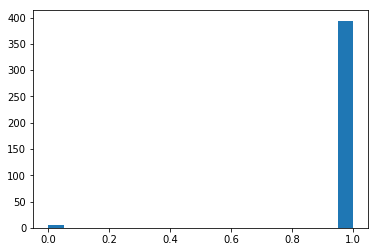

In [26]:
from verifier import Verifier
vf = Verifier(L_train_all, L_val_all, val_ground)

vf.train_gen_model()
vf.gen_model.learned_lf_stats()

vf.assign_marginals()
plt.hist(vf.train_marginals, bins=20)
plt.show()

In [27]:
vague_idx = vf.find_vague_points(b=0.6, thresh=0.2)
incorrect_idx = vf.find_incorrect_points(b=0.6)
#TODO call the function, print TP/FP/F1/P/R etc in pandas format
1-np.shape(incorrect_idx)[0]/float(np.shape(val_ground)[0])

0.45499999999999996